In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from flipper_training.experiments.ppo.eval import get_eval_rollout, log_from_eval_rollout, PPOExperimentConfig
import contextlib
from tqdm import tqdm
import pickle
import os

/Users/davidkorcak/.venv/lib/python3.12/site-packages/torchrl/__init__.py:43: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(


In [2]:
with open("../cross_eval_configs/cross_eval_seeds.txt") as f:
    seeds = list(map(int, f.readlines()))

print(seeds)

[12345, 67890, 11121, 31415, 92653, 58979, 32384, 62643, 38327, 95028]


In [6]:
run = "final_trunk_thesis_training_42_2025-05-09_21-01-13"

In [7]:
run_path = Path("../runs/ppo") / run
weights_step = "final"
config = OmegaConf.load(run_path / "config.yaml")
policy_weights_path = run_path / "weights" / f"policy_{weights_step}.pth"
vecnorm_weights_path = run_path / "weights" / f"vecnorm_{weights_step}.pth"

assert policy_weights_path.exists(), f"Policy weights not found at {policy_weights_path}"
assert vecnorm_weights_path.exists(), f"Vecnorm weights not found at {vecnorm_weights_path}"

In [8]:
config["num_robots"] = 16
config["objective_opts"]["cache_size"] = 10
config["engine_compile_opts"] = None
config = PPOExperimentConfig(**config)

In [9]:
test_configs = Path("../cross_eval_configs").glob("*.yaml")
test_configs = list(test_configs)
print(test_configs)

[Path('../cross_eval_configs/gauss_fine_hard.yaml'), Path('../cross_eval_configs/trunk_hard.yaml'), Path('../cross_eval_configs/gauss_coarse_hard.yaml'), Path('../cross_eval_configs/stairs_easy.yaml'), Path('../cross_eval_configs/barrier_easy.yaml'), Path('../cross_eval_configs/stairs_hard.yaml'), Path('../cross_eval_configs/gauss_fine_easy.yaml'), Path('../cross_eval_configs/gauss_coarse_easy.yaml'), Path('../cross_eval_configs/trunk_easy.yaml'), Path('../cross_eval_configs/barrier_hard.yaml')]


In [ ]:
results_per_config = {"training": []}
# original training config eval
for seed in seeds:
    config.seed = seed
    with contextlib.redirect_stdout(open(os.devnull, "w+")):
        with contextlib.redirect_stderr(open(os.devnull, "w+")):
            _, rollout = get_eval_rollout(config, policy_weights_path, vecnorm_weights_path)
            rollout_log = log_from_eval_rollout(rollout)
    results_per_config["training"].append(rollout_log)
print("Training config done")
# test configs eval
for test_cfg_path in tqdm(test_configs, desc="Test Configs", position=0):
    test_cfg = OmegaConf.load(test_cfg_path)
    config.objective_opts = test_cfg["objective_opts"]
    config.heightmap_gen_opts = test_cfg["heightmap_gen_opts"]
    config.objective = test_cfg["objective"]
    config.heightmap_gen = test_cfg["heightmap_gen"]
    result_logs = []
    for seed in tqdm(seeds, desc="Seeds", position=1):
        config.seed = seed
        with contextlib.redirect_stdout(open(os.devnull, "w+"):
            with contextlib.redirect_stderr(open(os.devnull, "w+")):
                _, rollout = get_eval_rollout(config, policy_weights_path, vecnorm_weights_path)
                rollout_log = log_from_eval_rollout(rollout)
        result_logs.append(rollout_log)
    results_per_config[test_cfg_path.name] = result_logs
    print(f"Config {test_cfg_path.name} done")

with open(f"../cross_eval_results/{run_path.name}results_eval.pkl", "wb") as f:
    pickle.dump(results_per_config, f)

Test Configs:  80%|████████  | 8/10 [59:06<14:46, 443.26s/it]


KeyboardInterrupt: 

In [17]:
with open(f"../cross_eval_results/{run_path.name}results_eval_incomplete.pkl", "wb") as f:
    pickle.dump(results_per_config, f)

In [8]:
with open(f"../cross_eval_results/{run_path.name}results_eval_incomplete.pkl", "rb") as f:
    results_per_config = pickle.load(f)

In [9]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    """
    Convert a list of dictionaries to a dictionary of lists.
    """
    dict_of_lists = {}
    for d in list_of_dicts:
        for k, v in d.items():
            if k not in dict_of_lists:
                dict_of_lists[k] = []
            dict_of_lists[k].append(v)
    return dict_of_lists

In [10]:
results_transposed = {k: list_of_dicts_to_dict_of_lists(v) for k, v in results_per_config.items()}
results_transposed.keys()

dict_keys(['stairs_hard.yaml', 'stairs_easy.yaml', 'barrier_easy.yaml', 'barrier_hard.yaml', 'gauss_coarse_hard.yaml', 'gauss_fine_easy.yaml', 'gauss_fine_hard.yaml', 'gauss_coarse_easy.yaml'])

In [ ]:
key2name = {
    "training": "Training Environment",
    "stairs_hard": "Stairs-Hard",
    "stairs_easy": "Stairs-Easy",
    "barrier_easy": "Barrier-Easy",
    "barrier_hard": "Barrier-Hard",
    "gauss_coarse_hard": "Gauss-Coarse-Hard",
    "gauss_fine_easy": "Gauss-Fine-Easy",
    "gauss_fine_hard": "Gauss-Fine-Hard",
    "gauss_coarse_easy": "Gauss-Coarse-Easy",
}

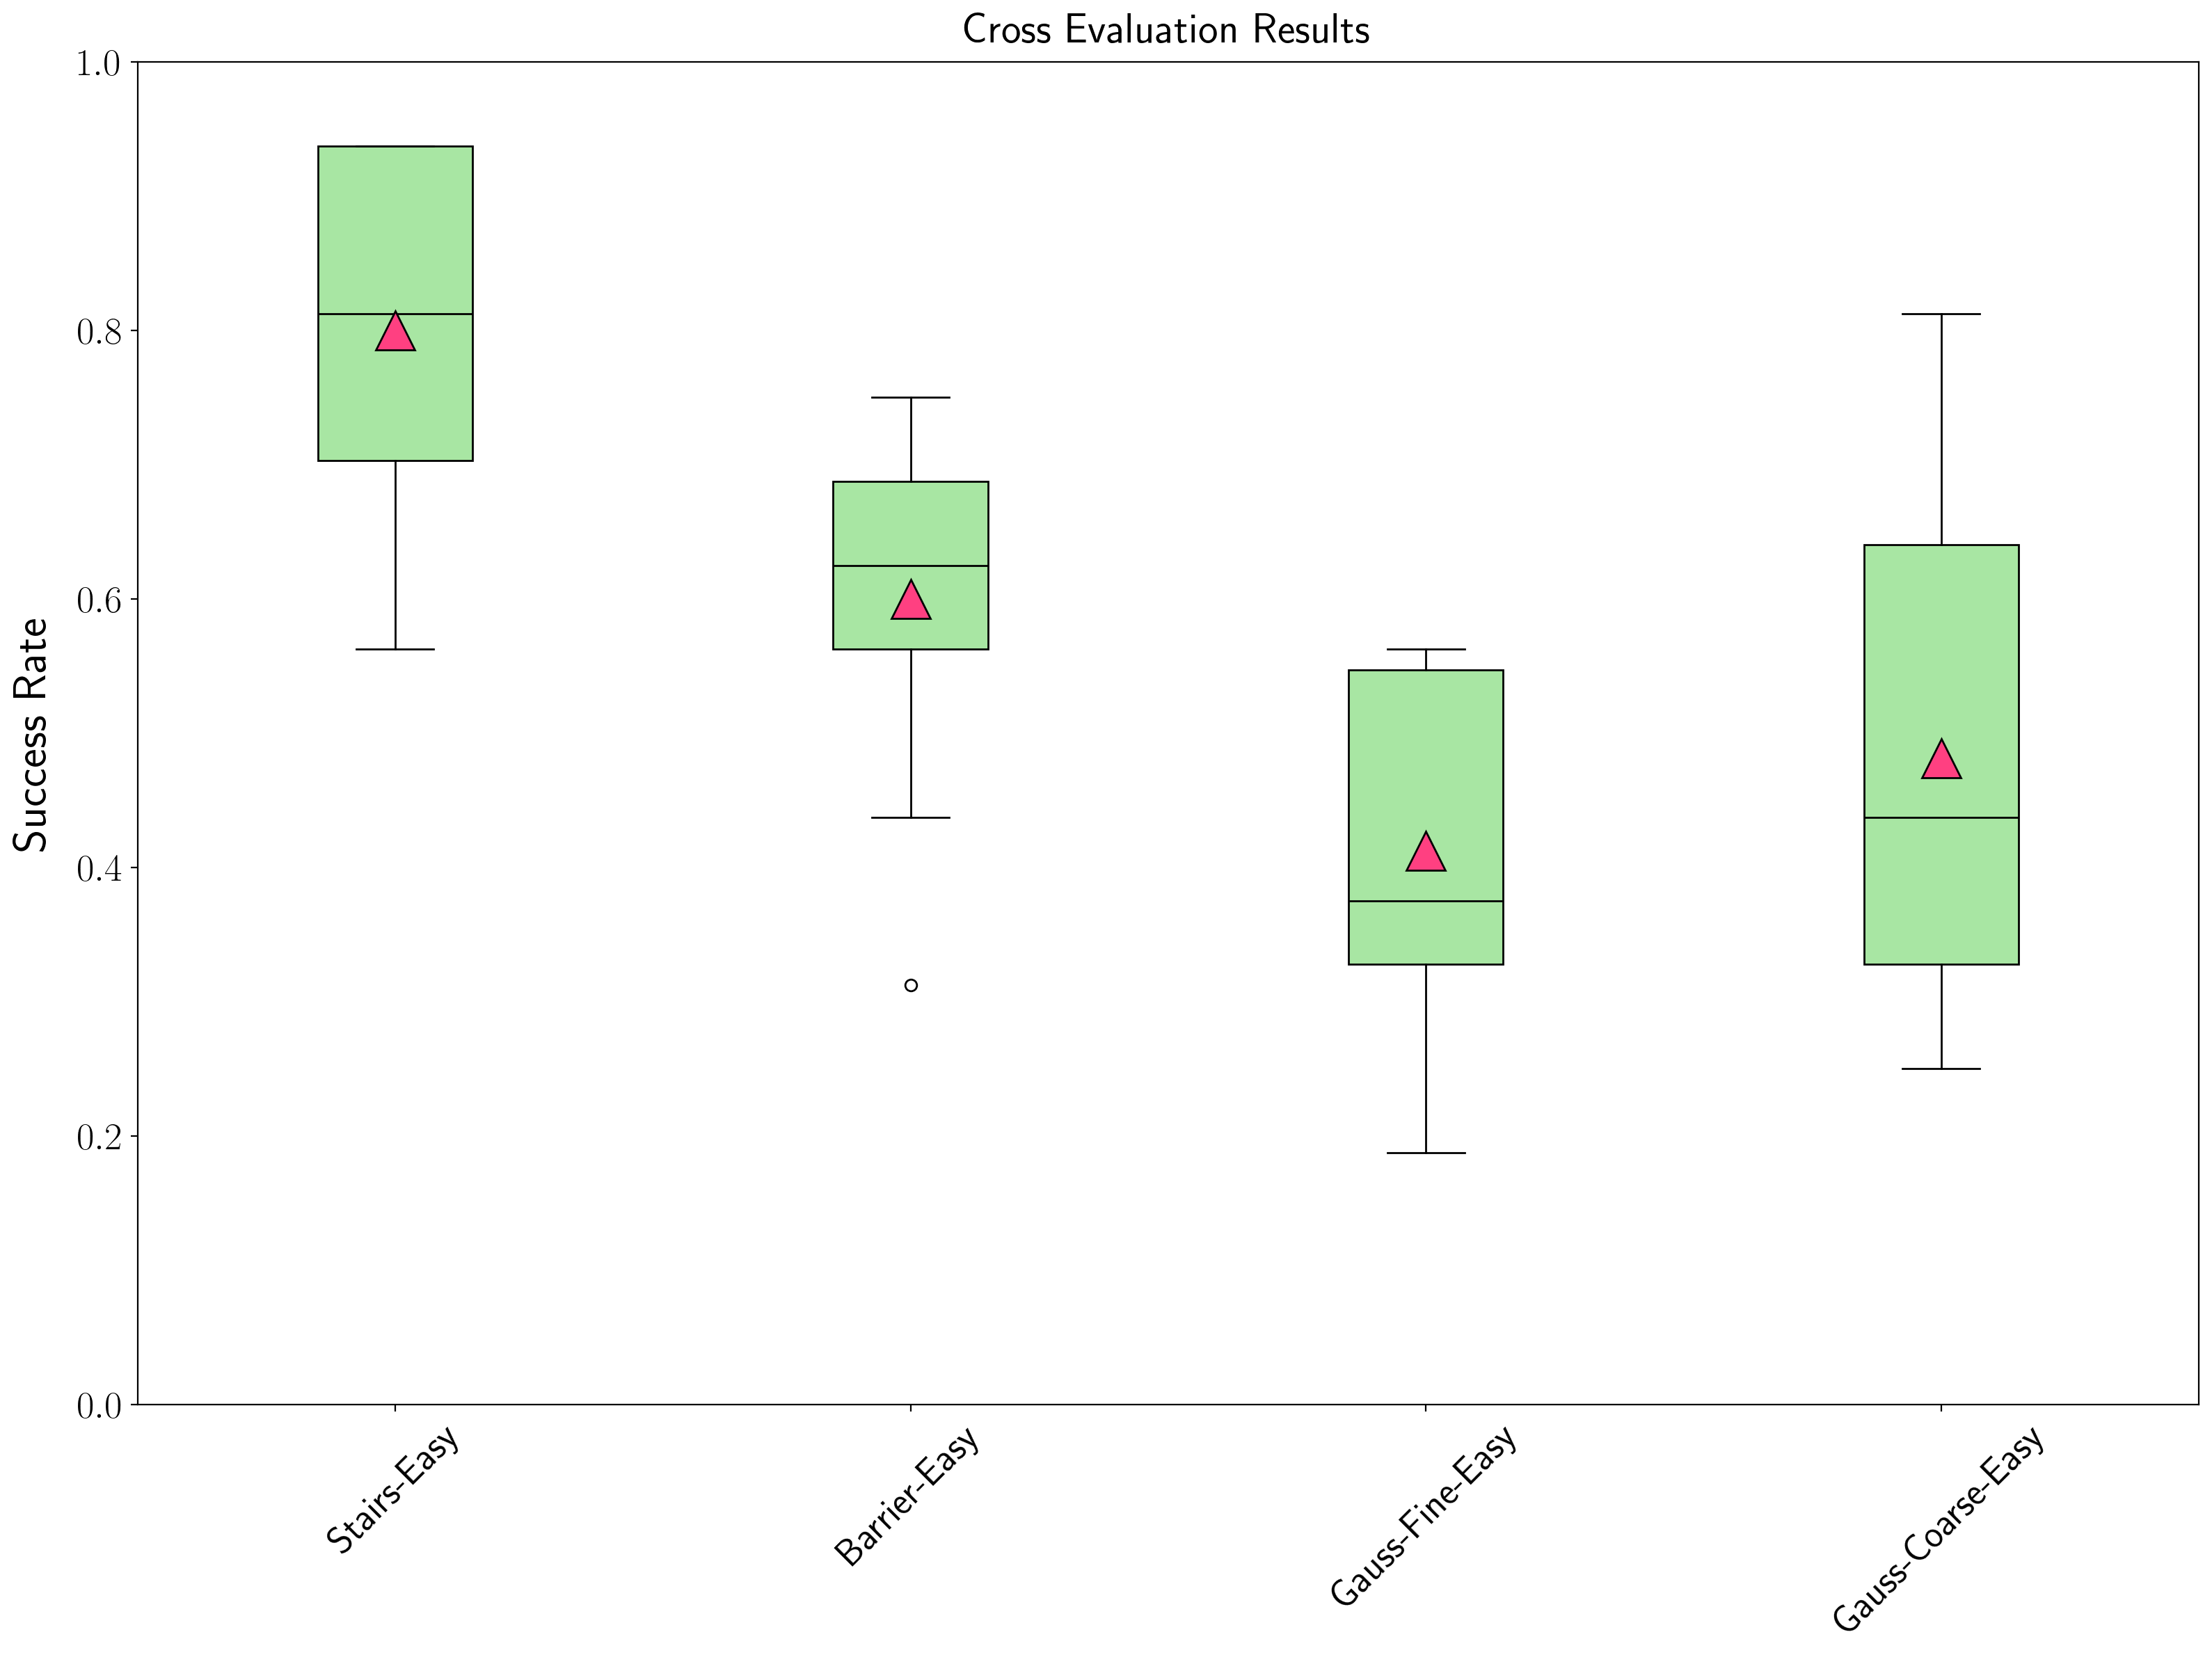

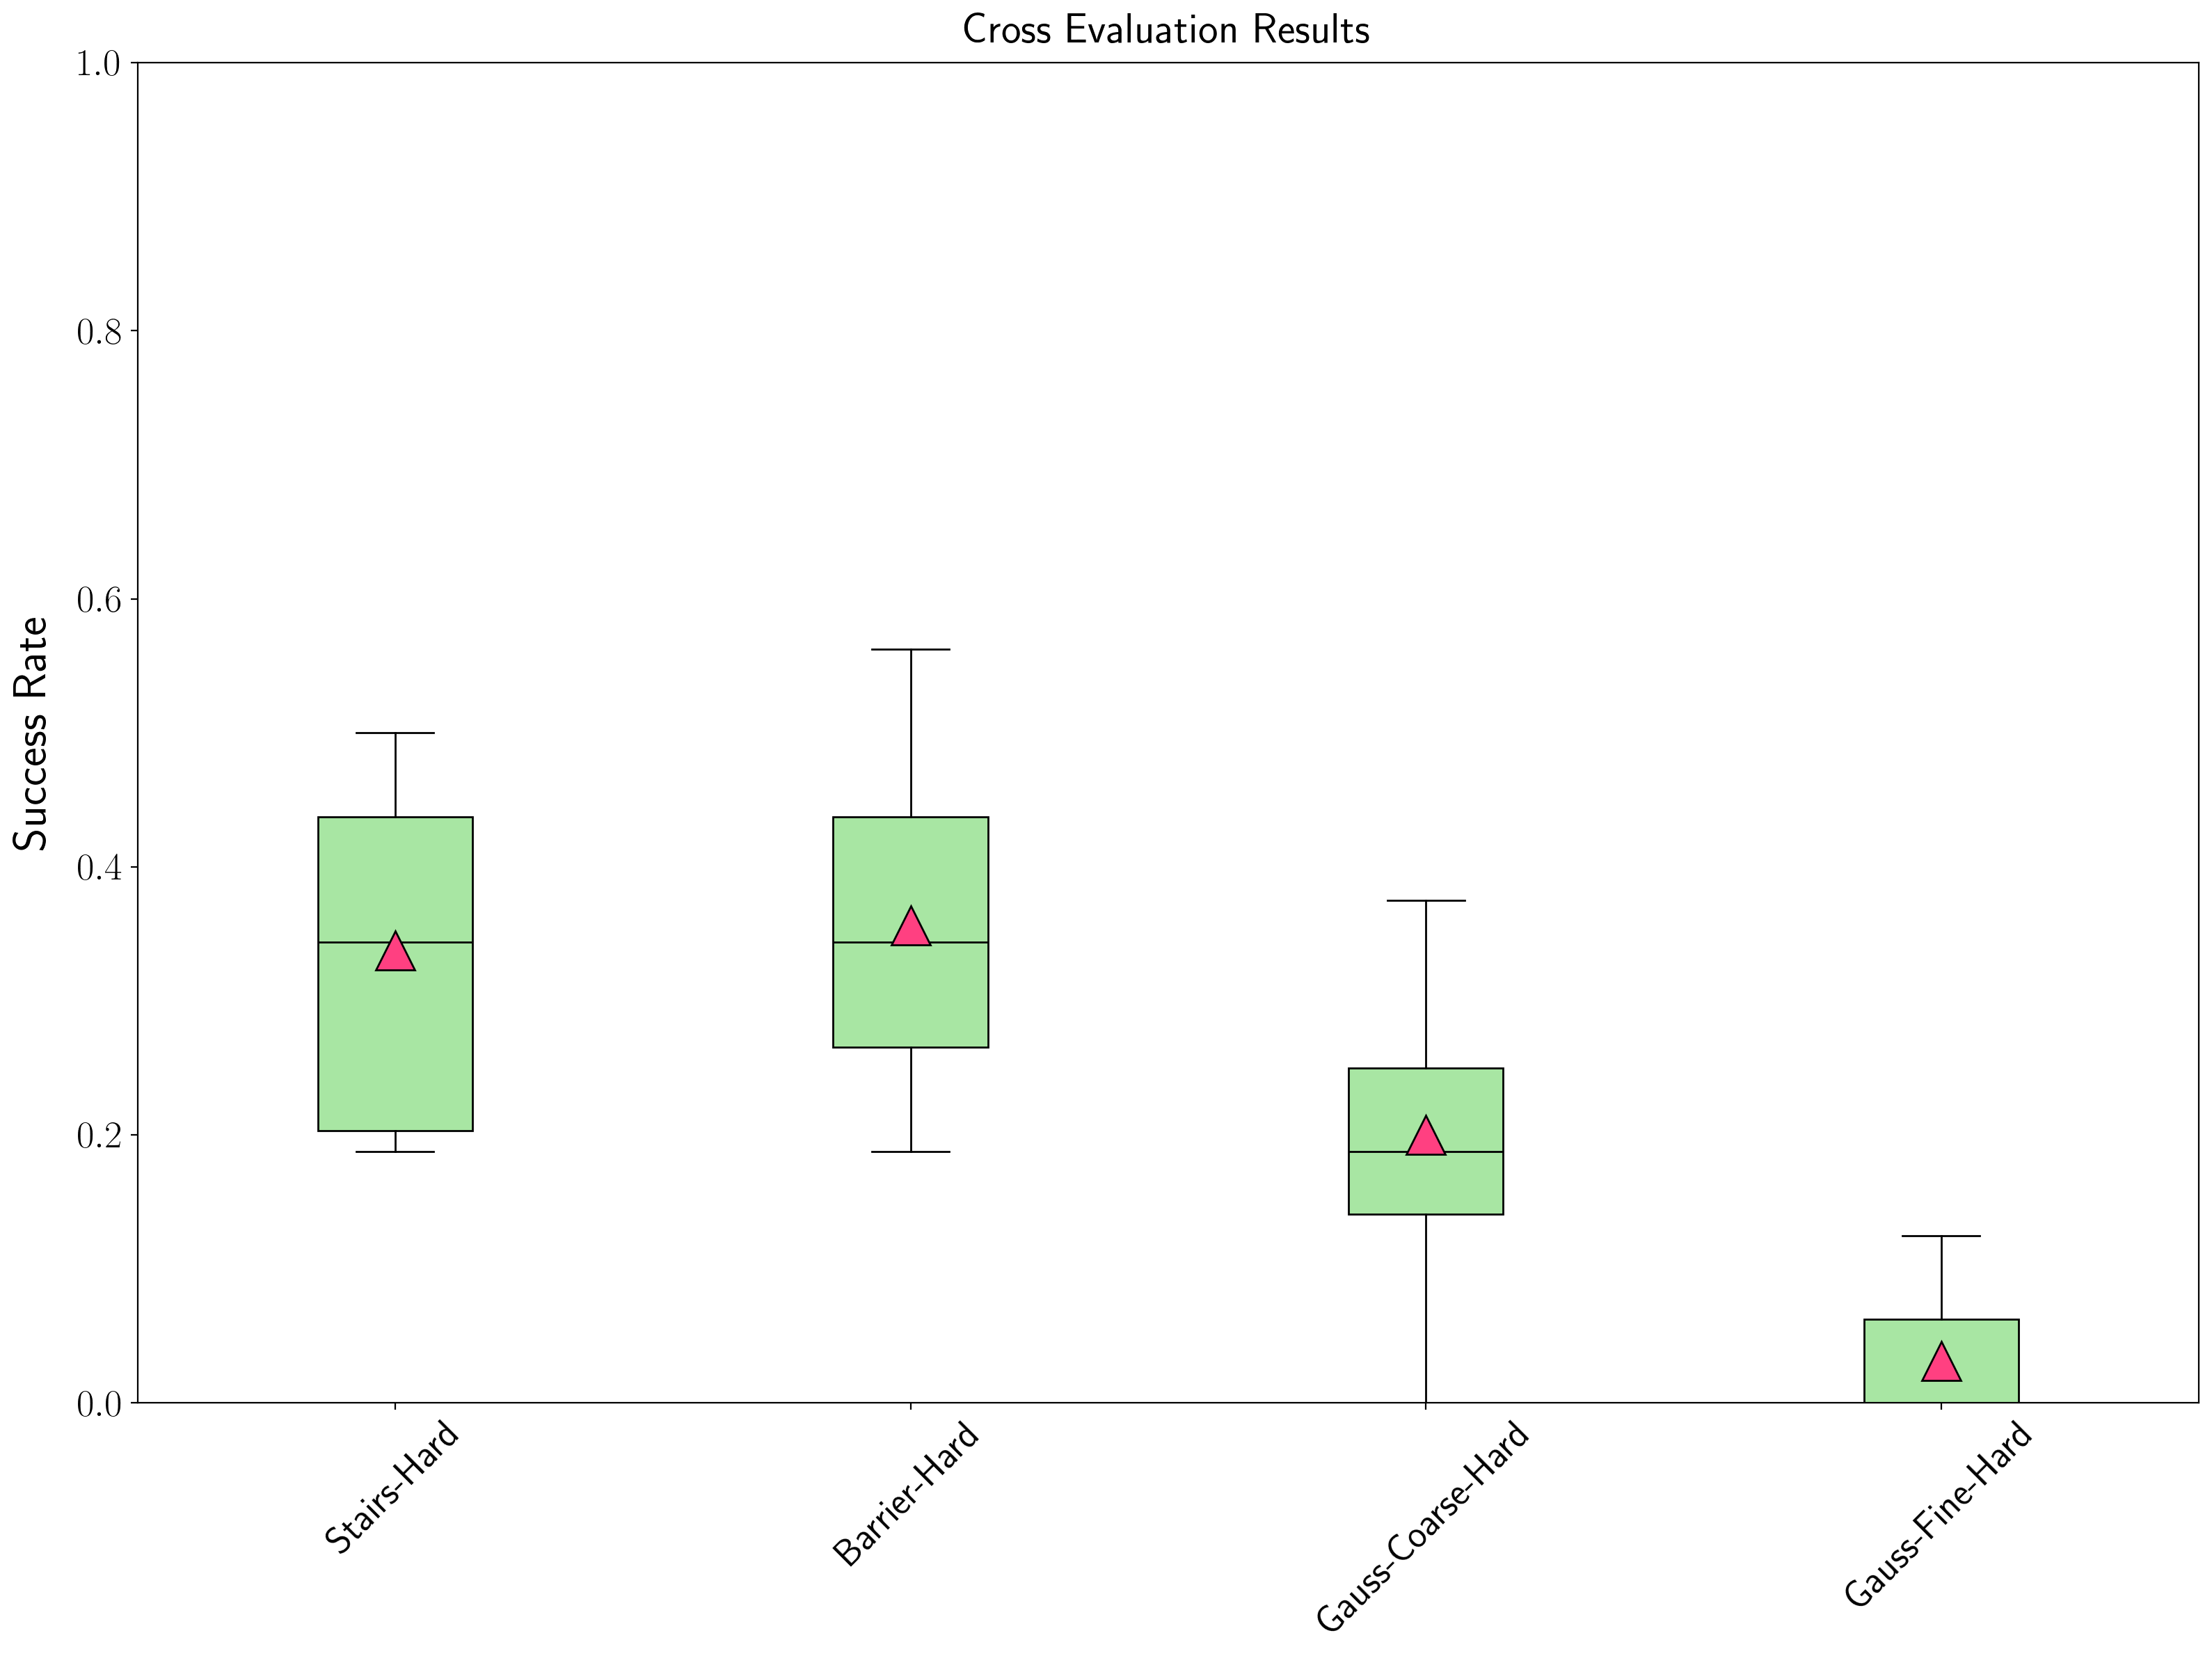

In [35]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True

# Separate keys for easy/training and hard/training
easy_keys = [k for k in results_transposed if "easy" in k or "training" in k]
hard_keys = [k for k in results_transposed if "hard" in k or "training" in k]

# Plot for easy + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Success Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
green_color = "#a8e6a3"
line_color = "black"
for i, k in enumerate(easy_keys):
    v = results_transposed[k]
    pct_succeeded = v["eval/pct_succeeded"]
    ax.boxplot(
        pct_succeeded,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=green_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#ff4081", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(easy_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in easy_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

# Plot for hard + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Success Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
for i, k in enumerate(hard_keys):
    v = results_transposed[k]
    pct_succeeded = v["eval/pct_succeeded"]
    ax.boxplot(
        pct_succeeded,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=green_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#ff4081", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(hard_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in hard_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

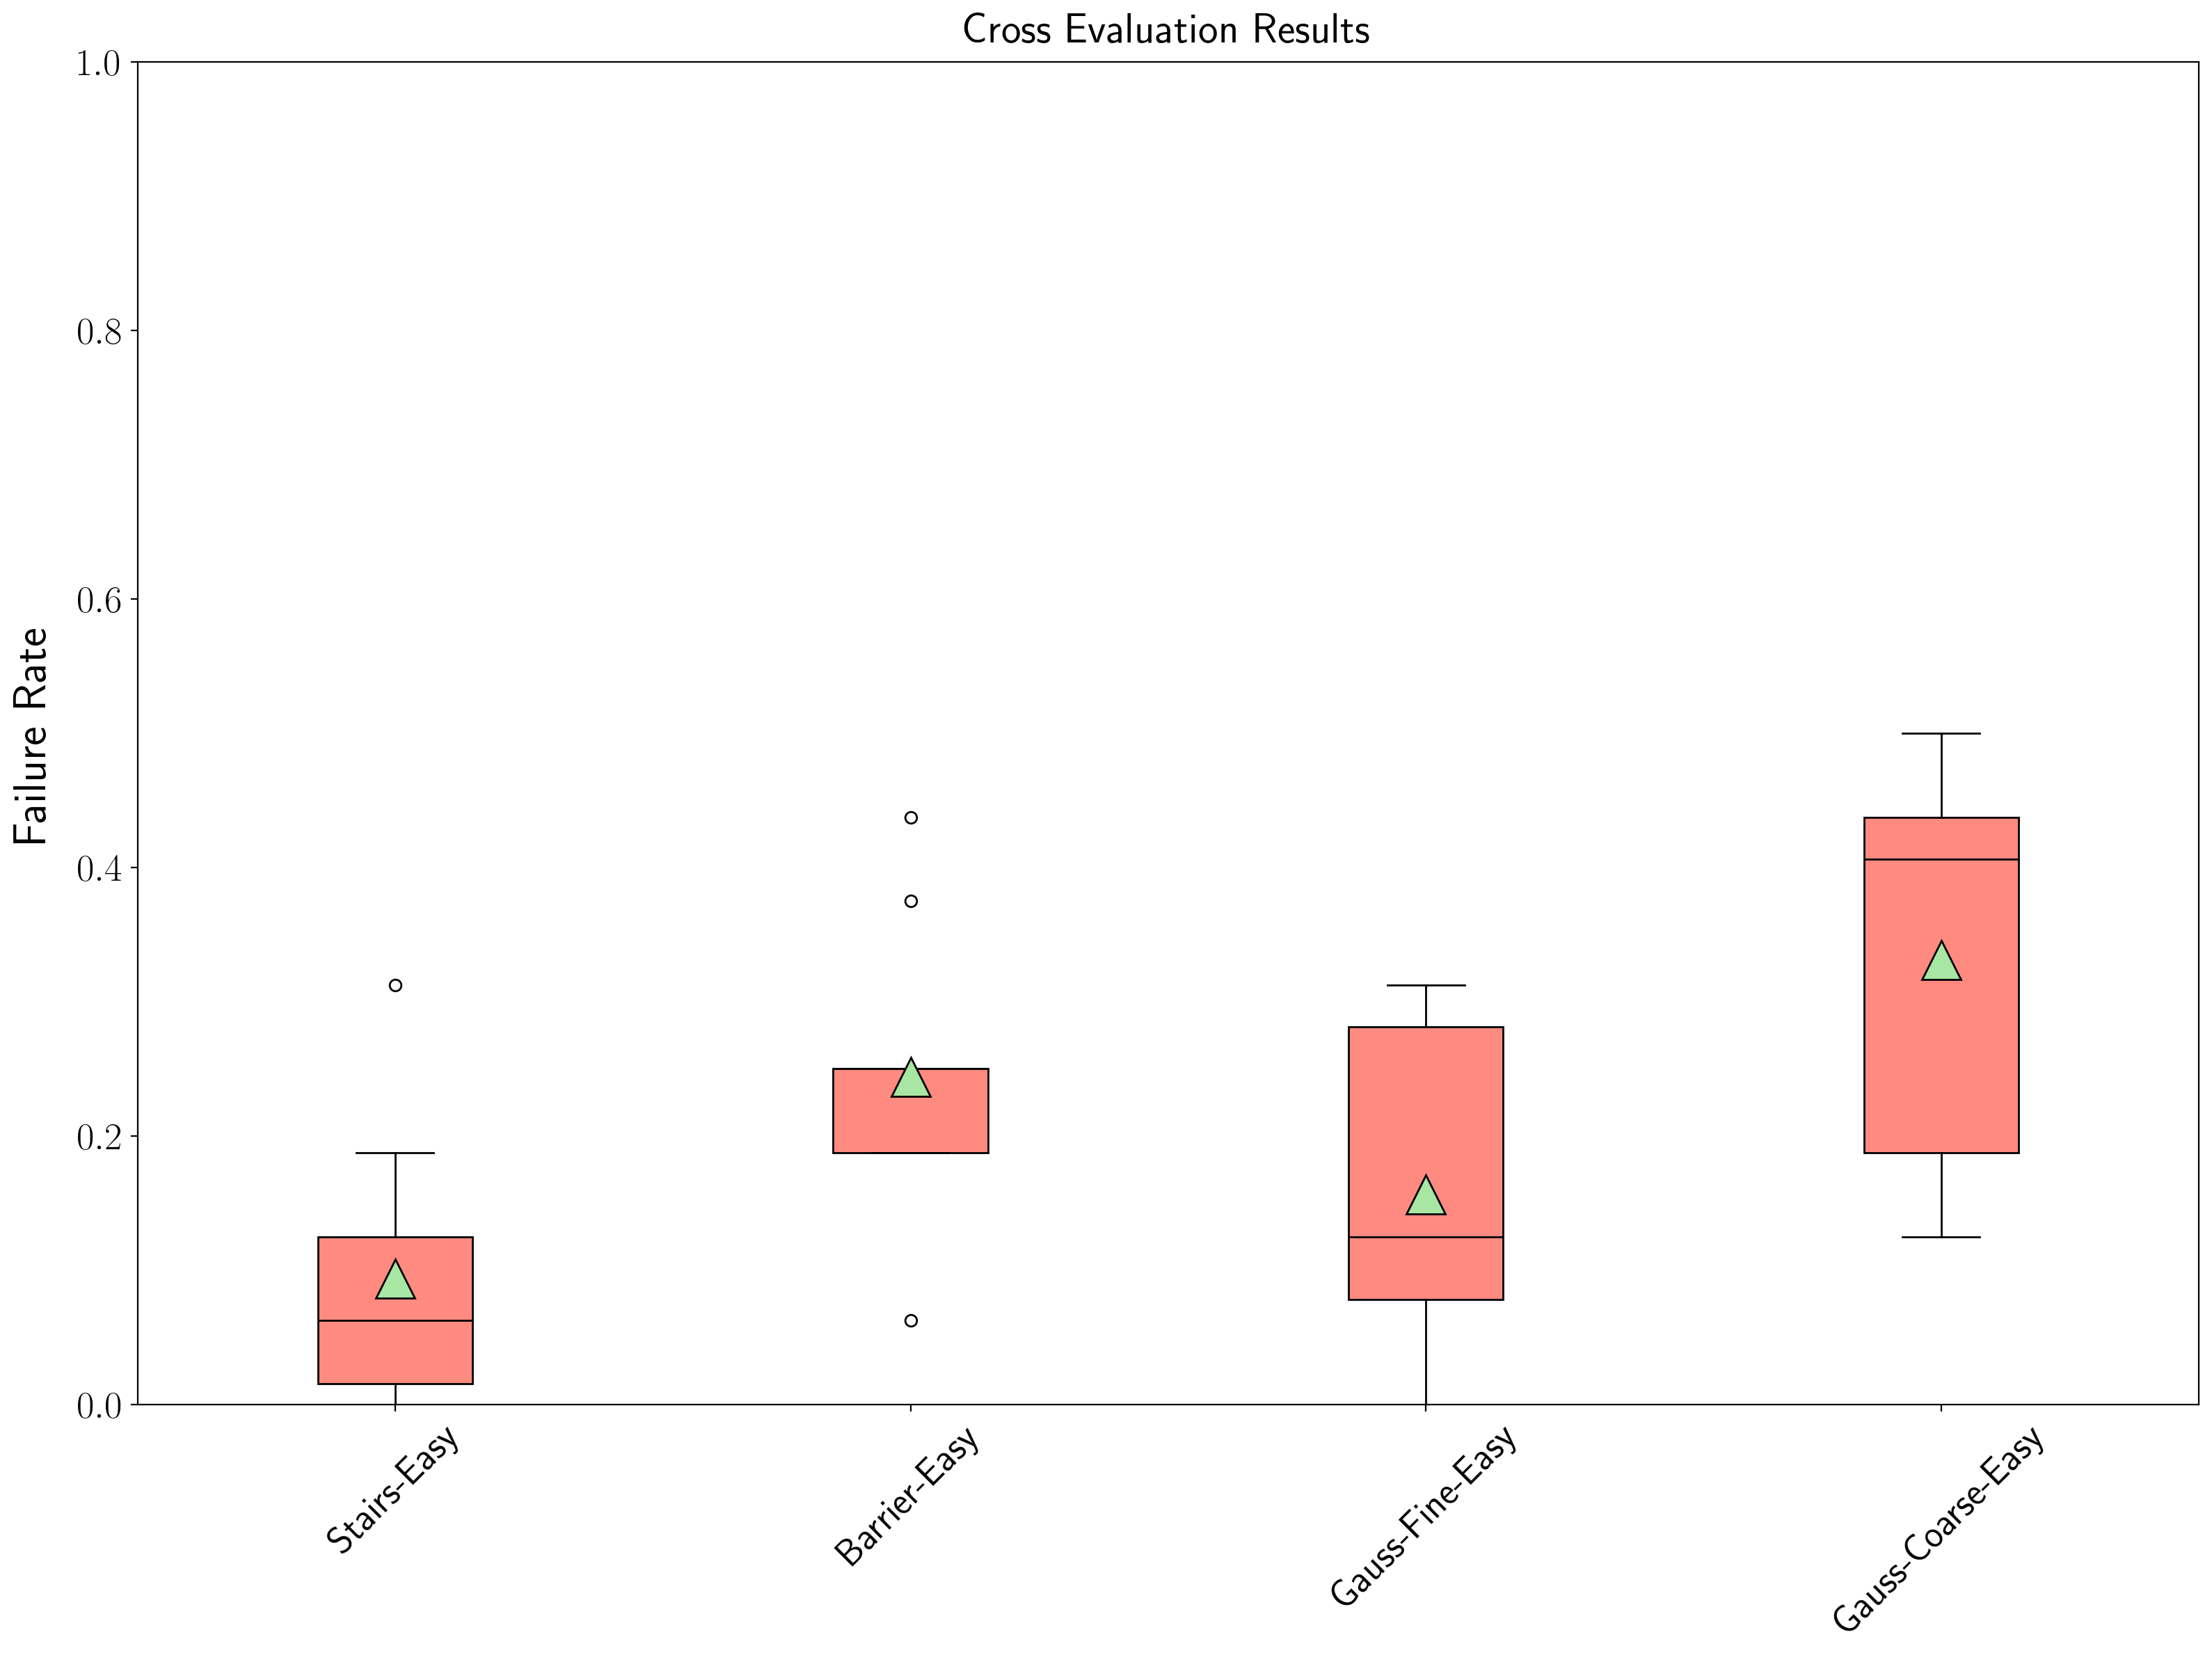

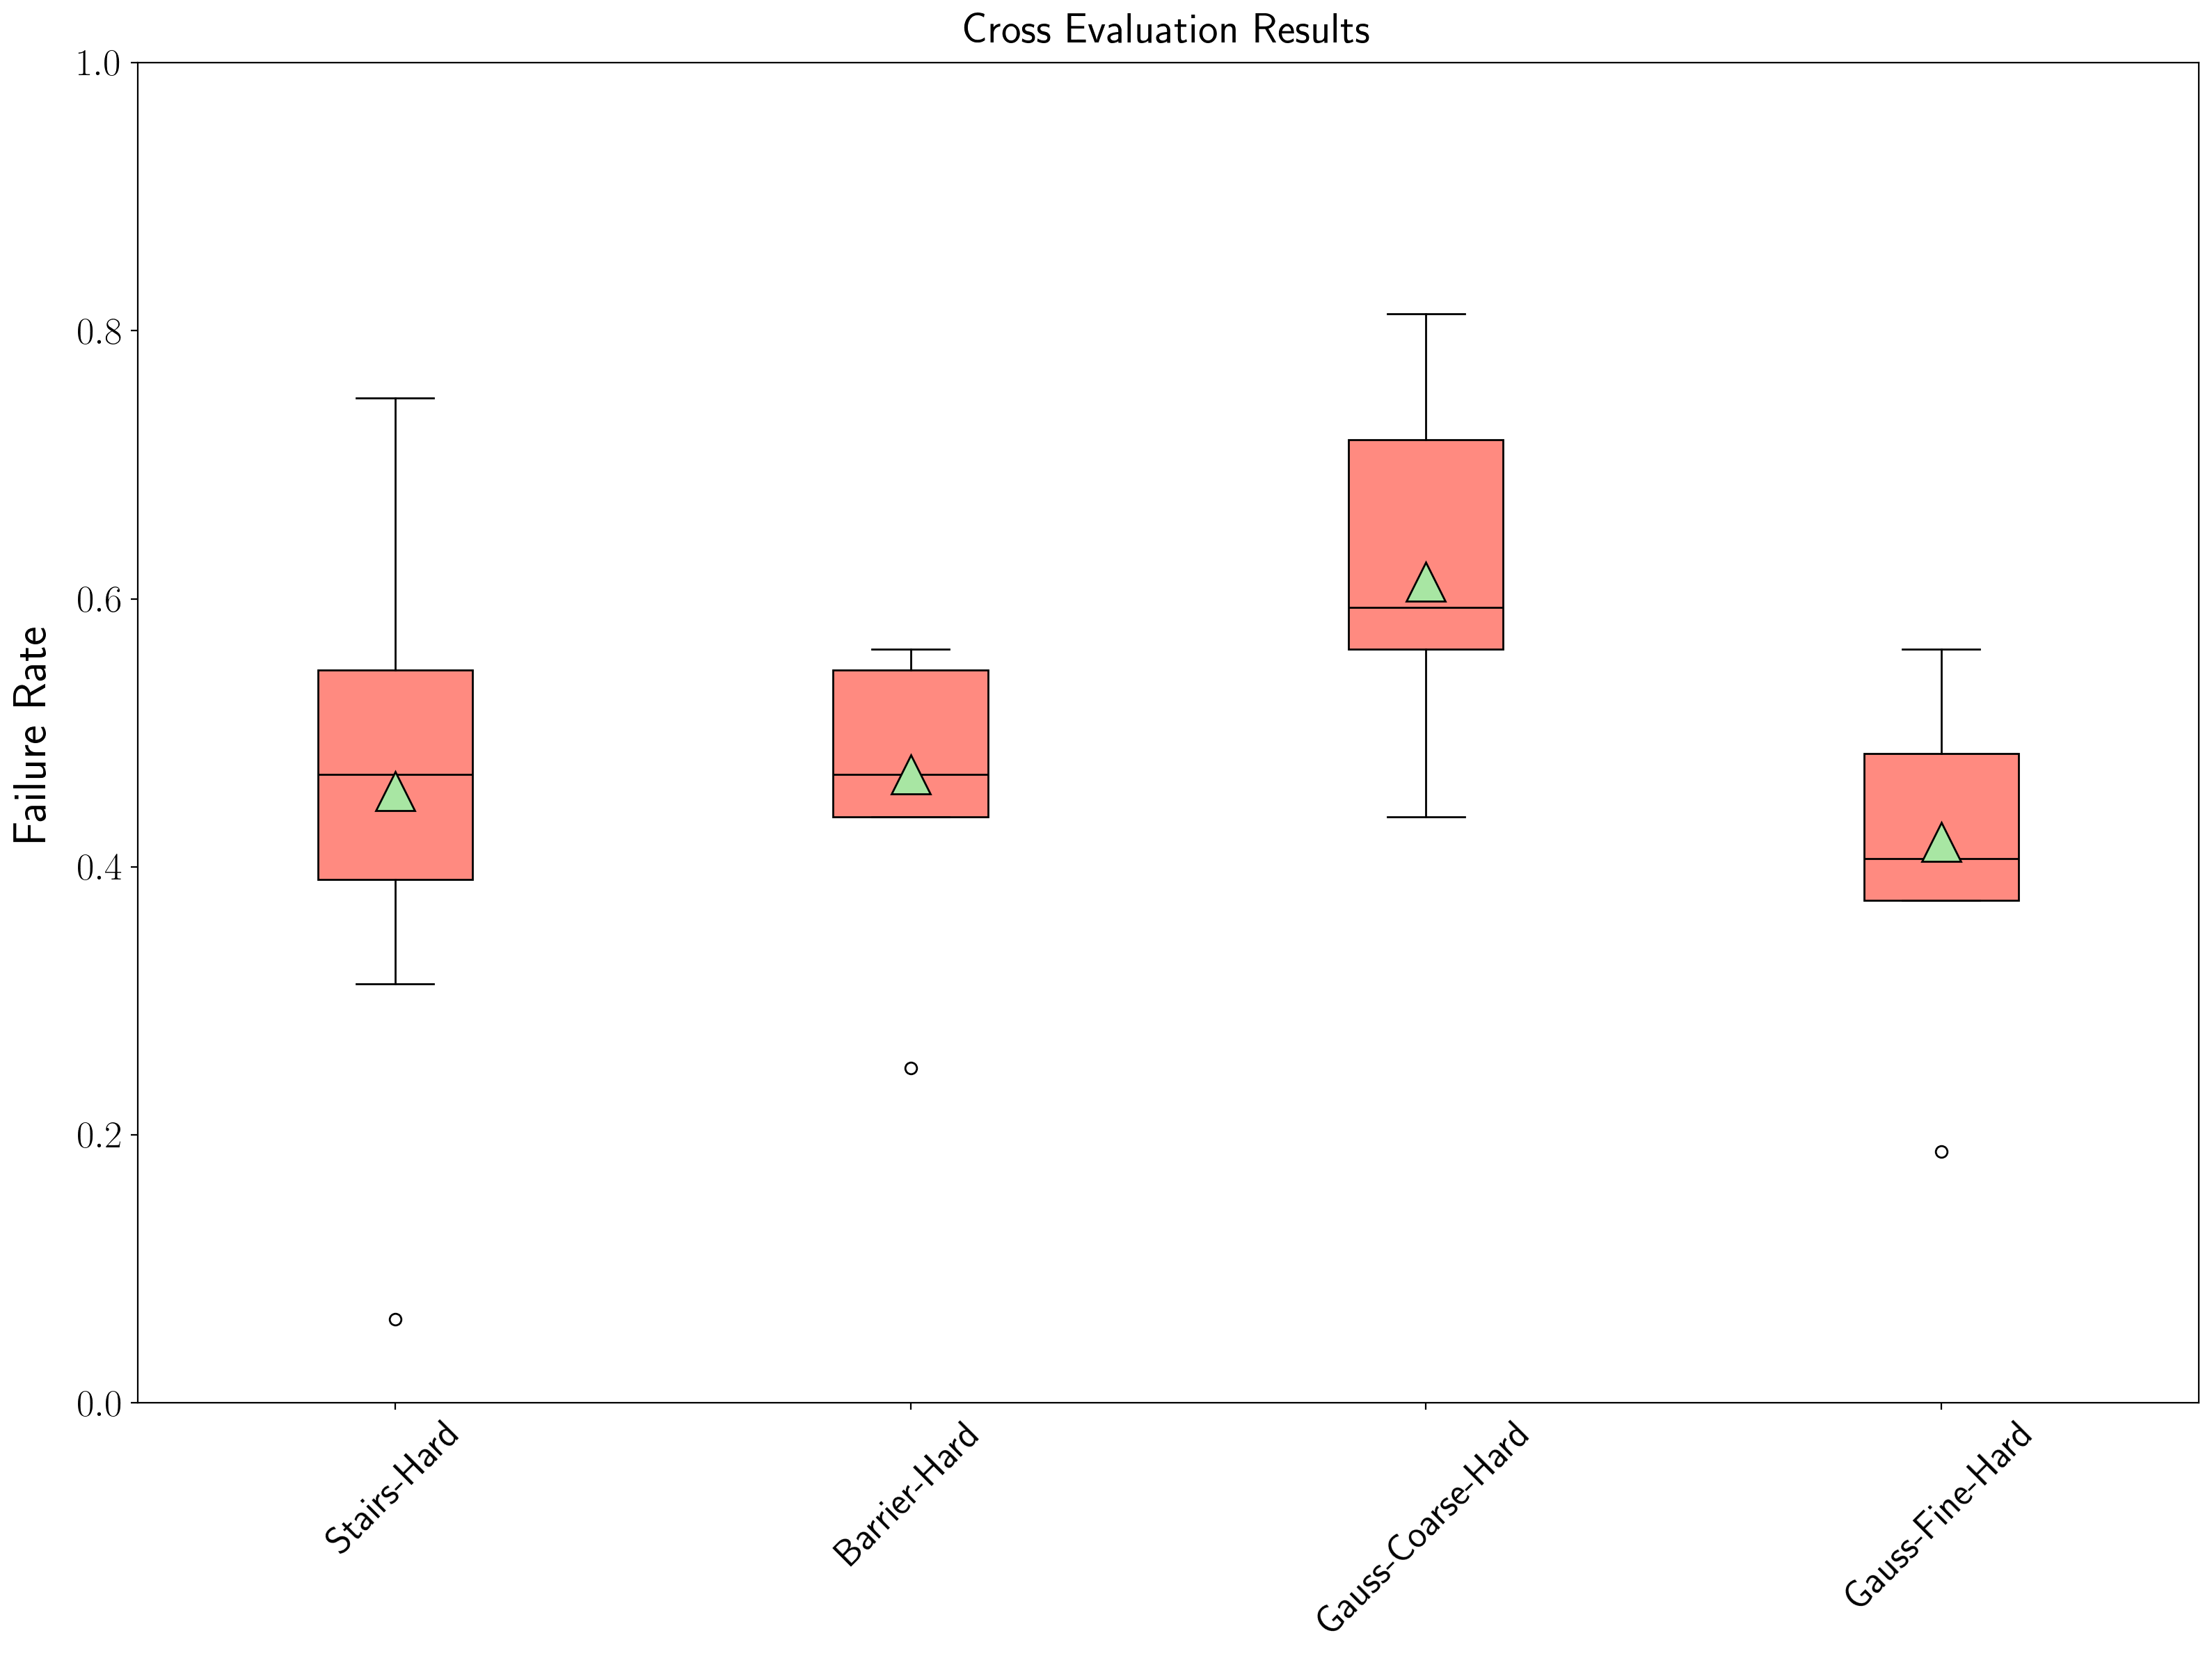

In [39]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True

# Separate keys for easy/training and hard/training
easy_keys = [k for k in results_transposed if "easy" in k or "training" in k]
hard_keys = [k for k in results_transposed if "hard" in k or "training" in k]

# Plot for easy + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Failure Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
red_color = "#ff8a80"
line_color = "black"
for i, k in enumerate(easy_keys):
    v = results_transposed[k]
    pct_failed = v["eval/pct_failed"]
    ax.boxplot(
        pct_failed,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=red_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#a8e6a3", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(easy_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in easy_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

# Plot for hard + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Failure Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
for i, k in enumerate(hard_keys):
    v = results_transposed[k]
    pct_failed = v["eval/pct_failed"]
    ax.boxplot(
        pct_failed,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=red_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#a8e6a3", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(hard_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in hard_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()